In [1]:
import numpy as np
# Some epoch configuration
srate = 512
epochLength = 10000
samples = int(np.floor(srate * epochLength/1000))

In [2]:
from typing import Tuple
def kaiserord(f: np.ndarray, a: np.ndarray, dev: np.ndarray, fs: float = 2) -> Tuple:
    """Kaiser window FIR filter design estimation parameters
    Parameters
    ----------
    f : ndarray
        Band edges. The length of `f` is the length of `2*len(a)-2`.
    a : ndarray
        Band amplitude. The amplitude is specified on the bands defined by `f`.
        Together, `f` and `a` define a piecewise-constant response function.
    dev : ndarray
        Maximum allowable deviation.
        `dev` is a vector the same size as `a` that specifies the maximum allowable
        deviation between the frequency response of the output filter and its band
        amplitude, for each band. The entries in dev specify the passband ripple
        and the stopband attenuation. Specify each entry in `dev` as a positive number,
        representing absolute filter gain (unit-less).
    fs : float, optional
        Sample rate in Hz. Use this syntax to specify band edges scaled to a particular
        application's sample rate. The frequency band edges in f must be from 0 to fs/2.
        Default is 2.

    Raises
    ------
    ValueError
        If the length of `f` is not same as `2*len(a)-2`.
        If the length `a` and `dev` is not the same.
        If `dev` includes minus value.

    Returns
    -------
    n : int
        Filter order.
    Wn : ndarray
        Normalized frequency band edges.
    beta : float
        The `beta` parameter to be used in the formula for a Kaiser window.
    ftype : string
        Filter type of filter('low', 'high', 'bandpass', 'stop', 'DC-0'
            or 'DC-1').
            Specified as one of the following.

            1. 'low' specifies a lowpass filter with cutoff frequency Wn.
               'low' is the default for scalar Wn.
            2. 'high' specifies a highpass filter with cutoff frequency Wn.
            3. 'bandpass' specifies a bandpass filter if Wn is a two-element vector.
               'bandpass' is the default when Wn has two elements.
            4. 'stop' specifies a bandstop filter if Wn is a two-element vector.
            5. 'DC-0' specifies that the first band of a multiband filter is
               a stopband.
               'DC-0' is the default when Wn has more than two elements.
            6. 'DC-1' specifies that the first band of a multiband filter is
               a passband.

    """
    if type(f) != np.ndarray:
        if type(f) == list:
            f = np.array(f)
        else:
            f = np.array([f])

    if type(a) != np.ndarray:
        if type(a) == list:
            a = np.array(a)
        else:
            a = np.array([a])

    if type(dev) != np.ndarray:
        if type(dev) == list:
            dev = np.array(dev)
        else:
            dev = np.array([dev])

    # Parameter check
    if len(f) != 2 * len(a) - 2:
        raise ValueError("The length of 'f' must be the length of 2*len(a)-2.")

    if np.any(a[0:len(a) - 2] != a[2:len(a)]):
        raise ValueError("Pass and stop bands in a must be strictly alternating.")

    if (len(dev) != len(a)) and (len(dev) != 1):
        raise ValueError("'dev' and 'a' must be the same size.")

    dev = np.min(dev)
    if dev <= 0:
        raise ValueError("'dev' must be larger than 0.")

    # Calcurate normalized frequency band edges.
    Wn = (f[0:len(f):2] + f[1:len(f):2]) / fs

    # Determine ftype
    if len(Wn) == 1:
        if a[0] > a[1]:
            ftype = 'low'
        else:
            ftype = 'high'
    elif len(Wn) == 2:
        if a[0] > a[1]:
            ftype = 'stop'
        else:
            ftype = 'bandpass'
    else:
        if a[0] > a[1]:
            ftype = 'DC-1'
        else:
            ftype = 'DC-0'

    # Calcurate beta
    A = -20 * np.log10(dev)
    beta = signal.kaiser_beta(A)

    # Calcurate n from beta and dev
    width = 2 * np.pi * np.min(f[1:len(f):2] - f[0:len(f):2]) / fs
    n = np.max((1, int(np.ceil((A - 8) / (2.285 * width)))))

    # If last band is high, make sure the order of the filter is even
    if ((a[0] > a[1]) == (len(Wn) % 2 == 0)) and (n % 2 == 1):
        n += 1

    if len(Wn) == 1:
        Wn = Wn[0]

    return int(n), Wn, beta, ftype

def fir1(n: int, Wn, ftype: str = 'default', window='hamming', scaleopt: bool = True) -> Tuple:
    """
    FIR filter design using the window method.

    This function computes the coefficients of a finite impulse response filter.
    The filter will have linear phase; it will be Type I if n is odd
    and Type II if numtaps is even.
    Type II filters always have zero response at the Nyquist frequency,
    so a ValueError exception is raised if firwin is called with n even
    and having a passband whose right end is at the Nyquist frequency.


    Parameters
    ----------
        n : int
            Filter order.
            `n` must be even if a passband includes the Nyquist frequency.

        Wn : float or 1D array_like
            Cutoff frequency of filter (expressed in the same units as fs)
            OR an array of cutoff frequencies (that is, band edges).
            In the latter case, the frequencies in `Wn` should be positive
            and monotonically increasing between 0 and 1.
            The values 0 and 1 must not be included in `Wn`.

        ftype : string, optional
            Filter type of filter('low', 'high', 'bandpass', 'stop', 'DC-0'
            or 'DC-1').
            Specified as one of the following.

            1. 'low' specifies a lowpass filter with cutoff frequency Wn.
               'low' is the default for scalar Wn.
            2. 'high' specifies a highpass filter with cutoff frequency Wn.
            3. 'bandpass' specifies a bandpass filter if Wn is a two-element vector.
               'bandpass' is the default when Wn has two elements.
            4. 'stop' specifies a bandstop filter if Wn is a two-element vector.
            5. 'DC-0' specifies that the first band of a multiband filter is
               a stopband.
               'DC-0' is the default when Wn has more than two elements.
            6. 'DC-1' specifies that the first band of a multiband filter is
               a passband.

        window : string or tuple of string and parameter values, optional
            Desired window to use. See 'scipy.signal.get_window' for a list of
            windows and required parameters.

        scaleopt : bool, optional
            Set to True to scale the coefficients so that the frequency response
            is exactly unity at a certain frequency. That frequency is either:

            - 0 (DC) if the first passband starts at 0 (i.e. pass_zero is True)
            - fs/2 (the Nyquist frequency) if the first passband ends at fs/2
              (i.e the filter is a single band highpass filter); center of
              first passband otherwise

    Returns
    -------
        system :a tuple of array_like describing the system.
            The following gives the number of elements in the tuple and
            the interpretation:

                * (num, den)

    Raises
    ------
        ValueError
            -If any value in `Wn` is less than or equal to 0 or greater
             than or equal to 1, if the values in `Wn` are not strictly
             monotonically increasing, or if `n` is even but a passband
             includes the Nyquist frequency.
            -If the length of `Wn` equals to 1 but `ftype` is defined to
             other than 'default', 'low', 'high'.
            -If the length of `Wn` equals to 2 but `ftype` is defined to
             other than 'default', 'bandpass', 'stop'.
            -If the length of `Wn` more than 2 but `ftype` is defined to
             other than 'default', 'DC-0', 'DC-1'.
            -If `ftype` is other than 'default', 'low', 'bandpass', 'high',
             'stop', 'DC-0', 'DC-1'.
    """

    # Default parameters
    filtertype = ['default', 'low', 'bandpass', 'high', 'stop', 'DC-0', 'DC-1']
    pass_zero = True

    # Filter type check
    if (ftype in filtertype) == False:
        raise ValueError("ftype must be 'default', 'low', 'bandpass', 'high'"
                         + ", 'stop', 'DC-0' or 'DC-1'.")

    # Filter length check
    if type(Wn) == float and (ftype in ['default', 'low', 'high']) == False:
        # When the length of Wn equals to 1.
        raise ValueError("If the length of Wn equals to 1, ftype must be"
                         + " 'default', 'low', or 'high'.")
    elif type(Wn) == list and len(Wn) == 2 and (ftype in ['default', 'bandpass', 'stop', 'DC-0', 'DC-1']) == False:
        # When the length of Wn equals to 2.
        raise ValueError("If the length of Wn equals to 2, ftype must be"
                         + " 'default', 'bandpass', 'stop', 'DC-0', 'DC-1'.")
    elif type(Wn) == list and len(Wn) >= 3 and (ftype in ['default', 'DC-0', 'DC-1']) == False:
        # When the length of Wn is greater than 2.
        raise ValueError("If the length of Wn is greater than 2, ftype must be"
                         + " 'default', 'DC-0', or 'DC-1'.")

    # Define default filter types
    if type(Wn) == float and ftype == 'default':
        # If the length of Wn equals to 1, the default filter type is low-pass
        ftype = 'low'

    if type(Wn) == list and len(Wn) == 2 and (ftype == 'default' or ftype == 'DC-0'):
        # If the length of Wn equals to 2, the default filter type is bandpass
        ftype = 'bandpass'

    if type(Wn) == list and len(Wn) >= 3 and ftype == 'default':
        # If the length of Wn is greater than 2, the default filter type is DC-0
        ftype = 'DC-0'

    if ftype in ['high', 'bandpass', 'DC-0']:
        pass_zero = False

    num = signal.firwin(n + 1, Wn, window=window, pass_zero=pass_zero,
                        scale=scaleopt)  # Numerator
    den = 1  # Denominator

    return num, den

import numpy as np
# Not to be confused with functions to be used on the Windows OS
# These window functions are similar to those found in the Windows toolbox of MATLAB
# Note that numpy has a couple of Window functions already:
# See: hamming, bartlett, blackman, hanning, kaiser
 
def tukeywin(window_length, alpha=0.5):
    '''The Tukey window, also known as the tapered cosine window, can be regarded as a cosine lobe of width \alpha * N / 2
    that is convolved with a rectangle window of width (1 - \alpha / 2). At \alpha = 1 it becomes rectangular, and
    at \alpha = 0 it becomes a Hann window.
 
    We use the same reference as MATLAB to provide the same results in case users compare a MATLAB output to this function
    output
 
    Reference
    ---------
    http://www.mathworks.com/access/helpdesk/help/toolbox/signal/tukeywin.html
 
    '''
    # Special cases
    if alpha <= 0:
        return np.ones(window_length) #rectangular window
    elif alpha >= 1:
        return np.hanning(window_length)
 
    # Normal case
    x = np.linspace(0, 1, window_length)
    w = np.ones(x.shape)
 
    # first condition 0 <= x < alpha/2
    first_condition = x<alpha/2
    w[first_condition] = 0.5 * (1 + np.cos(2*np.pi/alpha * (x[first_condition] - alpha/2) ))
 
    # second condition already taken care of
 
    # third condition 1 - alpha / 2 <= x <= 1
    third_condition = x>=(1 - alpha/2)
    w[third_condition] = 0.5 * (1 + np.cos(2*np.pi/alpha * (x[third_condition] - 1 + alpha/2))) 
 
    return w

In [3]:
def utl_normalise(signal_f, amplitude):
    
    m = abs(signal_f).max(0)
    # m = max(abs(signal_f[0]))
    print("Step 1")
    print(m)

#     if m != 0:
    try:
        signal_final = signal_f * (np.sign(m) / m) * amplitude
        print("Step 2")
        print(signal_final)
    except:
        pass
        
    return signal_final

def utl_apply_dvslopeshift(mean, deviation, slope, epochNumber, shift):
    # In our case, since we will be generating the EEG epoch by epoch, epochNumber should refer to current epoch no. 
    # In our case, deviation and shift may not be necessary and therefore this function has not been completed. 
    # There is no justification for applying a constant deviation slope or shift. 
    # What we want however is a good way to randomize the mean of e.g. alpha 
    
#     # Matlab
#     if nargin == 5, shift = 0; end

# if numel(mean) > 1
#     % in case more than one value is given, first recursively calling self
#     % without shift
#     for i = 1:numel(mean)
#         value(i) = utl_apply_dvslopeshift(mean(i), deviation(i), slope(i), epochNumber, maxEpoch, 0);
#     end
# else
#     % fixing applied deviation value between -/+ deviation
#     dv = deviation / 3 * randn();
#     if abs(dv) > deviation, dv = deviation * sign(dv); end
    
#     % getting slope
#     slope = slope * (epochNumber-1) / (maxEpoch-1);
    
#     % applying; using nansum because slope can be NaN when maxEpoch = 1
#     value = nansum([mean, dv, slope]);
# end

# if shift ~= 0
#     % adding shift
#     shiftvalue = shift / 3 * randn();
#     if abs(shiftvalue) > shift, shiftvalue = shift * sign(shiftvalue); end
#     value = value + shiftvalue;
# end

# end
    pass 
    

Step 1
0.17989446457821384
Step 2
[ 1.35907948e-05  5.64292202e-04  1.48593770e-03 ... -4.08282794e+01
 -3.71701765e+01 -3.30853123e+01]
[ 1.35907948e-05  5.64292202e-04  1.48593770e-03 ... -4.08282794e+01
 -3.71701765e+01 -3.30853123e+01]


(-80, 25)

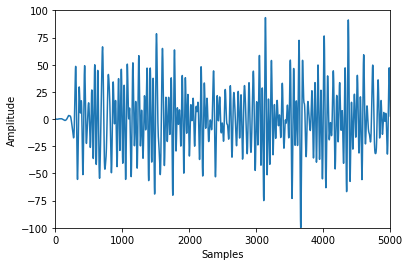

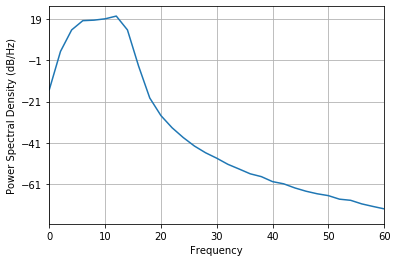

In [4]:
import numpy as np 
import scipy.signal as signal

def GenerateERSP(frequency, max_amplitude, phase, modulation):
    
    '''
    frequency = Frequency band in the following form: [low transition start, low transition end, high transition start, 
    high transition end] in Hz. in the latter case, a white noise signal will be filtered using a FIR filter 
    with the given band edge frequencies.
    
    This FIR filter is a Kaiser window FIR filter. 
    '''
    

    if len(frequency) == 1:
        print("Pure sine wave")
    elif len(frequency) == 4:
        # From matlab:
        # c = kaiserord(frequency, [0 1 0], [0.05 0.01 0.05], srate, 'cell');
        # b = fir1(c{:});

        # Translated:
        n, Wn, beta, ftype = kaiserord(frequency, np.array([0, 1, 0]), np.array([0.05, 0.01, 0.05]), srate)
        num, den = fir1(n, Wn, ftype)
        signal_f = np.random.rand(1, max([int(samples), 5*len(num)])) - 0.5
        signal_filtered = signal.lfilter(num, den, signal_f)
    
        # removing padding
        signal_filtered = signal_filtered[0, int(np.floor(signal_filtered.shape[1]/2 - samples/2)+1):int(np.floor(signal_filtered.shape[1]/2 + samples/2)+1)]

    signal_filtered = utl_normalise(signal_filtered, max_amplitude)
    return signal_filtered

x = GenerateERSP([3, 5, 12, 14], 100, [], [])

# print(x)

from matplotlib import pyplot as plt 
plt.plot(x)
plt.xlim([0, 5000])
plt.ylim([-100, 100])
print(x)
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.figure()
plt.psd(x, Fs=srate) 
plt.xlim([0, 60])
plt.ylim([-80, 25])

5120
1
5122
Step 1
0.17358838988602604
Step 2
[-1.91656505e-04  2.29823886e-05  8.94466128e-04 ...  8.31096671e+01
  9.02040052e+01  9.61678069e+01]
5120
case B


(-80, 25)

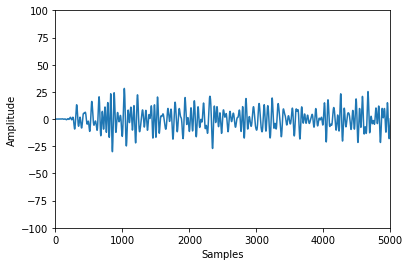

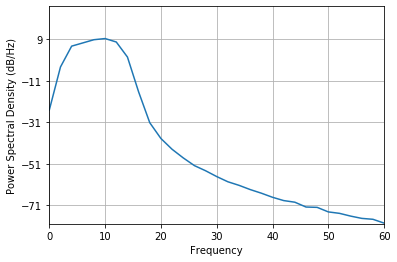

In [10]:
#  A variant of GenerateERSP for 'burst' and 'invburst' modulation.
def GenerateERSPModulated(frequency, max_amplitude, phase, modulation, modLatency, modWidth, modTaper, modMinRelAmplitude):
    
#     epochLength = 257   # modified to make samples = 131... is this reasonable?
#     samples = int(np.floor(srate * epochLength/1000)) 
    
    if len(frequency) == 1:
        print("Pure sine wave")
    elif len(frequency) == 4:
        n, Wn, beta, ftype = kaiserord(frequency, np.array([0, 1, 0]), np.array([0.05, 0.01, 0.05]), srate)
        num, den = fir1(n, Wn, ftype)
        signal_f = np.random.rand(1, max([int(samples), 5*len(num)])) - 0.5
        signal_filtered = signal.lfilter(num, den, signal_f)

        # removing padding
        print(len(signal_filtered[0, :]))
        print(int(np.floor(signal_filtered.shape[1]/2 - samples/2)+1))
        print(int(np.floor(signal_filtered.shape[1]/2 + samples/2)+1)+1)
        signal_filtered = signal_filtered[0, int(np.floor(signal_filtered.shape[1]/2 - samples/2)):int(np.floor(signal_filtered.shape[1]/2 + samples/2)+1)]
        
#         signal_filtered = np.transpose(signal_filtered)
    signal_filtered = utl_normalise(signal_filtered, max_amplitude)
    print(len(signal_filtered))
    
    ## modulation section 
    if modulation == 'burst' or modulation == 'invburst':
        latency = int(np.floor((modLatency/1000)*srate) + 1)
        width = int(np.floor((modWidth/1000)*srate))
        taper = modTaper
        
        # generating tukey window for burst
        if width < 1: 
            width = 0
         
        win = tukeywin(width, taper)
        win = np.transpose(win)
    
        # positioning window around latency
        if latency > np.ceil(width/2):
            win = np.hstack((np.zeros(int(latency - np.ceil(width/2))), win))  # append horizontally 
        else:
            print("case B")
            win[1:int(np.ceil(width / 2) - latency + 1)] = 0
    
        # fitting tukey window to signal
        if len(win) > samples:
            win = win[0:samples]
        elif len(win) < samples:
            win = np.append(win, np.zeros((1, int(samples) - len(win))))
        
        # inverting in case of inverse burst
        if modulation == 'invburst':
            win = 1 - win
    
        if max(win) - min(win) != 0:
            # normalising between modMinRelAmplitude and 1
            win = modMinRelAmplitude + (1-modMinRelAmplitude) * (win - min(win)) / (max(win) - min(win));

#     else:
#         # window is flat; if all-zero, it should be modMinRelAmplitude instead
#         if ~win,win = repmat(modMinRelAmplitude, size(win))
    
        # applying the modulation
#         print(signal_filtered.shape)
#         print(win.shape)
        signal_filtered = signal_filtered * win;
    
    signal_filtered = np.expand_dims(signal_filtered, axis=1)  # make shape consistent with noise signal
    return signal_filtered

x = GenerateERSPModulated([3, 5, 12, 14], 100, [], 'burst', 5, 20, 0.5, 0.3)
plt.plot(x)
plt.xlim([0, 5000])
plt.ylim([-100, 100])
plt.xlabel("Samples")
plt.ylabel("Amplitude")

# print(x.transpose().tolist()[0])
x = x.transpose().tolist()[0]

plt.figure()
plt.psd(x, Fs=srate) 
plt.xlim([0, 60])
plt.ylim([-80, 25])

[[ 0.12508165 -0.19748616 -0.10577438 ...  0.14669622  0.41239774
   0.21199974]]
Step 1
[0.12508165 0.19748616 0.10577438 ... 0.14669622 0.41239774 0.21199974]
Step 2
[[ 100. -100. -100. ...  100.  100.  100.]]
[[ 100. -100. -100. ...  100.  100.  100.]]
[[ 100. -100. -100. ...  100.  100.  100.]]


(0, 60)

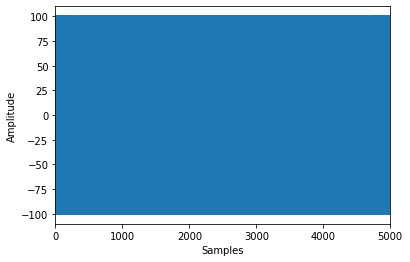

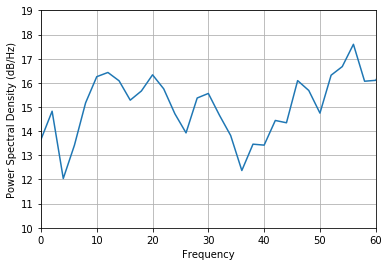

In [6]:
def GenerateColoredNoise(n, uniform_dist_range, noise_alpha):
    '''Purpose: Generates a discrete colored noise vector of size n with power 
    spectrum distribution of alpha
    White noise is sampled from Uniform (-range,range) distribution
       
    Usage: n - problem size
    uniform_dist_range - range of the underlying Uniform distribution
    noise_alpha - resulting colored noise has 1/f^alpha power spectrum
    
    '''

    # Generate the coefficients Hk
    hfa = np.zeros((2*n, 1))
    hfa[0] = 1.0
    
    for i in range(1, n+1):
        hfa[i] = hfa[i-1] * (0.5 * noise_alpha + (i-2+1)) / (i-1+1)  # coordinates are changed from Matlab code
    hfa[n+1:2*n+1] = 0.0
    
    # Fill Wk with white noise 
    wfa_1 = np.array(-uniform_dist_range + 2 * uniform_dist_range * np.random.rand(n, 1))
    wfa_2 = np.zeros((n, 1))
    wfa = np.append(wfa_1, wfa_2, 0)  # append vertically 

    # Perform the discrete Fourier transforms of Hk and Wk 
    fh = np.fft.fft(hfa)
    fw = np.fft.fft(wfa)
    
    # Multiply the two complex vectors.
    fh = fh[1:n+2]
    fw = fw[1:n+2]
    fw = fh * fw
  
    # This scaling is introduced only to match the behavior of the Numerical Recipes code...
    fw[1] = fw[1] / 2
    fw[-1] = fw[-1] / 2
    
    # Take the inverse Fourier transform of the result. 
    fw = np.append(fw, np.zeros((n-1,1)), 0)  # append vertically 
    x = np.fft.ifft(fw)
    x = 2 * x[1:n+1].real # Discard the second half of IFT 
    
    return x


### now, translate noise_generate_signal_fromclass
def GenerateNoiseSignal(color, epochLength, srate, amplitude):
    samples = int(np.floor(srate * epochLength/1000));
    
    if color == 'white-unif':
        signal = np.random.rand(1, samples) - 0.5
    elif color == 'pink-unif':
        signal = GenerateColoredNoise(samples, 1, 1)
    elif color == 'brown-unif':
        signal = GenerateColoredNoise(samples, 1, 2)
    elif color == 'blue-unif':
        signal = GenerateColoredNoise(samples, 1, -1)
    elif color == 'purple-unif':
        signal = GenerateColoredNoise(samples, 1, -2)
        
    # center around zero 
    signal = signal - np.mean(signal)
    
    print(signal)
    # normalising to have the maximum (or minimum) value be (-)amplitude
    signal = utl_normalise(signal, amplitude)
    print(signal)
    return signal

brown_unif_noise = GenerateNoiseSignal('white-unif', epochLength, srate, 100)
print(brown_unif_noise)

plt.figure()
plt.plot(brown_unif_noise[0])
plt.xlim([0, 5000])
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.figure()
plt.psd(brown_unif_noise[0], Fs=srate) 
plt.xlim([0, 60])

In [7]:
# Import leadfield matrix created on MATLAB
from scipy.io import loadmat
leadfield = loadmat('32_channel_nyhead_lf.mat')
# Out:  
#       the leadfield containing the following fields
#            .lf   - the leadfield, containing projections in three
#                           directions (xyz) for each source, in a 
#                           nchannels x nsources x 3 matrix
#            .orientation - a default orientation for each source. for the
#                           New York Head, this gives dipole orientations
#                           perpendicular to the cortical surface
#            .pos         - xyz MNI coordinates of each source
#            .chanlocs    - channel information in EEGLAB format
lf = leadfield['nyhead_lf_test'][0][0][0]  # extract the leadfield matrix 
orientation = leadfield['nyhead_lf_test'][0][0][1] # default orientations (orthogonal)
pos = leadfield['nyhead_lf_test'][0][0][2] 
chanlocs = leadfield['nyhead_lf_test'][0][0][3]

FileNotFoundError: [Errno 2] No such file or directory: '32_channel_nyhead_lf.mat'

In [ ]:
import random
import sys
def CreateComponent(location, n, signal, component_list, leadfield, absolute_mode):
    '''
    Compiles the required information to form a brain activity component. 
    
    Input: 
    location - desired location x, y, z coordinates of the activity, in a nested list format OR simply 'random'.
    n - relevant for when using 'random' for location; defines how many components to generate. 
    signal - defines the signal to assign to the location(s). 
    component_list - defines the component list to append the output to. Should be [] in first usage.
    leadfield - defines the leadfield - assign the output of loadmat to this.
    absolute_mode - set to True in order to disable the search nearest point function and instead strictly follow the 
                    list of coordinates given in the 'location' argument when searching.
    
    Output:
    component_list - updated list of components
    '''
    
    lf = leadfield['nyhead_lf_test'][0][0][0]  # extract the leadfield matrix 
    orientation = leadfield['nyhead_lf_test'][0][0][1] # default orientations (orthogonal)
    pos = leadfield['nyhead_lf_test'][0][0][2] 
    chanlocs = leadfield['nyhead_lf_test'][0][0][3] 
    
    selected_positions = []
    if location == 'random':
        selected_positions = random.sample(range(pos.shape[0]+1), n)
    elif absolute_mode == False:  # if a location is specified through coordinates or list of coordinates, search nearest points
        for i in location:
            distances = ((pos[:,0] - i[0]) ** 2) + ((pos[:,1] - i[1]) ** 2) + ((pos[:,2] - i[2]) ** 2) ** 0.5
            selected_positions.append(np.argmin(distances))
    elif absolute_mode == True:
        pos_rounded = np.around(pos).astype(int).tolist()  # round to whole numbers
        for i in location:
            if i in pos_rounded:
                selected_positions.append(pos_rounded.index(i))
#                 print(pos_rounded[pos_rounded.index(i)])
#                 print(pos[pos_rounded.index(i)])

#     print(selected_positions)

    for i in selected_positions:
#         position_to_lookup = pos[i]
        
        component = {
            "sourceIdx": i,
            "signal": signal,
            "projection": lf[:,i,:],
            "orientation": orientation[i],
            "position": pos[i],
        }
        component_list.append(component)

    return component_list

    
CreateComponent('random', 2, 'test', component_list = [], leadfield=leadfield, absolute_mode=False)

In [ ]:
# Using this, we will now prepare the components and project.
def utl_add_sensornoise(data, mode, value):
    if mode == 'amplitude':
#         data = data + utl_normalise(np.random.rand(len(data)*2-1), value)   # conflict with latest changes in scalp generator
        # can be fixed if needed
        print('sensor noise not supported yet')
    elif mode == 'snr':
        # perhaps can be implemented if needed 
        print('snr not supported yet')
    return data 

def GenerateScalpData(component_list, leadfield, srate, sensorNoise):
#     epochLength = 1000 #ms
#     samples = np.floor(srate * epochLength/1000)
    
    scalpdata = np.zeros((len(chanlocs[0]), int(samples)))

#     scalpdata = zeros(numel(leadfield.chanlocs), floor((epochs.length/1000)*epochs.srate), epochs.n)

    componentdata = np.zeros((len(chanlocs[0]), int(samples), len(component_list)))
#     print("componentdata shape " + str(componentdata.shape))
    #     componentdata = zeros(numel(leadfield.chanlocs), floor((epochs.length/1000)*epochs.srate), numel(component)) 

    for i in range(len(component_list)):
        # obtaining component's signal
        componentsignal = component_list[i]["signal"]
#         sourcedata[i, :, 0] = componentsignal  # not sure what is the purpose of this 
        
        # obtaining the source
        sourceidx = component_list[i]["sourceIdx"]
        
        # obtaining orientation 
        orient = component_list[i]["orientation"] 
        
        # projecting signal 
        componentdata[:, :, i] = ProjectActivity(leadfield, componentsignal, sourceidx, orient, normaliseLeadfield=True, normaliseOrientation=True)

    # combining projected component signals into single epoch
    scalpdata[:, :] = np.sum(componentdata, 2)  #  sum along last axis
    
    # adding sensor noise (doesn't work yet)
    scalpdata = utl_add_sensornoise(scalpdata, 'amplitude', sensorNoise);
    
    return scalpdata


def ProjectActivity(leadfield, componentsignal, sourceidx, orient, normaliseLeadfield, normaliseOrientation): 
#    Original SEREEGA documentation:
#    In:
#       leadfield - a leadfield struct
#       signal - 1-by-n array, the activation signal to be projected
#       sourceIdx - source index of the source in the leadfield
#       orientation - [x, y, z] orientation of the source to use
#
# Optional (key-value pairs):
#       normaliseLeadfield - 1|0, whether or not to normalise the
#                            leadfields before  projecting the signal to
#                            have the most extreme value be either 1 or -1,
#                            depending on its sign. default: 0
#       normaliseOrientation - 1|0, as above, except for orientation
#
# Out:
#       scalpdata - channels x samples array of simulated scalp data
    lf = leadfield['nyhead_lf_test'][0][0][0]  # extract the leadfield matrix 
    orientation = leadfield['nyhead_lf_test'][0][0][1] # default orientations (orthogonal)
    pos = leadfield['nyhead_lf_test'][0][0][2] 
    chanlocs = leadfield['nyhead_lf_test'][0][0][3]
    
    signal_list = []; position_list = []
    for i in component_list:
        signal_list.append(i["signal"])
        position_list.append(i["position"])
    
    # Getting leadfield 
    projection = np.squeeze(lf[:,sourceidx,:])

    signal = componentsignal
    orientation = orient
    
    if normaliseLeadfield == True:
#         projection = utl_normalise(projection, 1)  # to fix utl_normalise 
        pass
    
    if normaliseOrientation == True:
#         orientation = utl_normalise(orientation, 1)
        pass
    
#     print(signal.shape); print(orientation.shape)
    projdata = np.dot(projection, np.transpose(np.hstack((signal * orientation[0],
                                                         signal * orientation[1],
                                                         signal * orientation[2]   # check orientation shape to confirm these 3 dims are right
                                                        ))))
    
    return projdata 

In [ ]:
from matplotlib import pyplot as plt
# Prepare components and test the scalp data generator. 

'''
GenerateERSPModulated(frequency, max_amplitude, phase, modulation, 
                      modLatency, modWidth, modTaper, modMinRelAmplitude) 
'''
noise = brown_unif_noise
resting = GenerateERSPModulated([4.8, 5, 12, 12.2], 5, [], 'none', [], [], [], [])
target = GenerateERSPModulated([4.8, 5, 12, 12.2], 5, [], 'burst', 300, 150, 0.7, 0.6)  

component_list = CreateComponent('random', 200, noise, component_list=[], leadfield=leadfield, absolute_mode=False)

x = GenerateScalpData(component_list, leadfield, srate, sensorNoise=0.5)
print(x.shape) # channels x samples 
eeg = plt.plot(x[:,:])

In [ ]:
from math import exp
'''
Mapping of velocity vector to PSD/amplitude space 
'''
print(len(np.arange(-1, 1.1, 0.001).tolist()))
# Generate pre-calculated table of the mapping.
delta_amplitude_table = np.empty([2100, 2100, 2])
x_count = 0
for x in np.arange(-1, 1.1, 0.001).tolist():
    
    y_count = 0
    for y in np.arange(-1, 1.1, 0.001).tolist():
        
        current_x = round(x, 3); current_y = round(y, 3)
        A = np.array([[1, -1], [1, 1]]); B = np.array([exp(current_x), exp(current_y)])
        delta = np.linalg.solve(A, B)
        delta_signs = [np.sign(delta[0]), np.sign(delta[1])]
    
        # Not sure, but the relationship between PSD and amplitude can be said to be PSD = amplitude^2?
        delta_amplitude_C4 = delta_signs[0] * abs(delta[0]) ** 0.5 
        delta_amplitude_C3 = delta_signs[1] * abs(delta[1]) ** 0.5 
        
        delta_amplitude_table[x_count, y_count, 0] = delta_amplitude_C4
        delta_amplitude_table[x_count, y_count, 1] = delta_amplitude_C3
        
        y_count = y_count + 1
    x_count = x_count + 1

print(delta_amplitude_table.shape)
print(delta_amplitude_table[13, 8, 1])  # accessing the Vx=0.3, Vy=-0.2, C3.   (0=C4, 1=C3) 

# For convenience/debugging only~~
easy_access_reference = []
for i in np.arange(-1, 1.1, 0.001).tolist():
    easy_access_reference.append(round(i, 3))
print(easy_access_reference[8])

In [ ]:
# Adjust the component preparation to be suitable for our project...
# With each iteration, the workflow needs to start from here (from defining the target signal with the appropriate amp.)
# (max_amplitude is the second argument of GenerateERSPModulated)

C3_current_amplitude = 0; C4_current_amplitude = 0  # initial 

# Input
recorded_vx = 13.12142155223
recorded_vy = 4.13535352352

i=0
while recorded_vx > 1 or recorded_vy > 1:
    recorded_vx = recorded_vx / 2 
    recorded_vy = recorded_vy / 2
    i = i + 1
    
scaling_factor = 2 ** i    # scaling_factor to be multiplied back to the output velocity after decoder 
# print(scaling_factor)

# Adjust incoming velocity vector into 1 d.p. 
recorded_vx = round(recorded_vx, 3); recorded_vy = round(recorded_vy, 3)
x_index = easy_access_reference.index(recorded_vx); y_index = easy_access_reference.index(recorded_vy)
C3_delta_amplitude = delta_amplitude_table[x_index, y_index, 1]
C4_delta_amplitude = delta_amplitude_table[x_index, y_index, 0]
C3_current_amplitude = C3_current_amplitude + C3_delta_amplitude
C4_current_amplitude = C4_current_amplitude + C4_delta_amplitude
print(C3_current_amplitude, C4_current_amplitude)

noise = brown_unif_noise
resting = GenerateERSPModulated([4.8, 5, 12, 12.2], 5, [], 'none', [], [], [], [])
target_C3 = GenerateERSPModulated([4.8, 5, 12, 12.2], C3_current_amplitude, [], 'burst', 30, 20, 0.9, 0.25)
target_C4 = GenerateERSPModulated([4.8, 5, 12, 12.2], C4_current_amplitude, [], 'burst', 30, 20, 0.9, 0.25)

component_list = []
component_list = CreateComponent('random', 5, noise, component_list=component_list, leadfield=leadfield, absolute_mode=False)
component_list = CreateComponent([[19, -15, 62]], 1, target_C4, component_list=component_list, leadfield=leadfield, absolute_mode=False)
component_list = CreateComponent([[-19, -15, 62]], 1, target_C3, component_list=component_list, leadfield=leadfield, absolute_mode=False)
component_list = CreateComponent([[19, -15, 62], [-19, -15, 62]], 2, resting, component_list=component_list, leadfield=leadfield, absolute_mode=False)

x = GenerateScalpData(component_list, leadfield, srate, sensorNoise=0.5)
print(x.shape)
eeg = plt.plot(x[:,:])

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', None)
# Mapping of velocity to alpha power and amplitude ~~ 2nd version 
def sigmoidfunction_wish(v, mode, gain):
    if mode == 'C3_x':
        a = 1 / (1 + exp(gain * v))    
    elif mode == 'C4_x':
        a = 1 / (1 + exp(-gain * v))
    elif mode == 'C3_y' or mode == 'C4_y':
        a = 1 / (1 + exp(gain * (v-0.6))) 
    return a

def sigmoidfunction_classic(v, mode, gain):
    if mode == 'C3_x' or mode == 'C3_y' or mode == 'C4_y':
        a = 1 / (1 + exp(gain * (v-0.6)))    
    elif mode == 'C4_x':
        a = 1 / (1 + exp(-gain * (v+0.6)))
    return a    

# Plotting of the sigmoid function 
x = np.linspace(-1,1,100)
y = []
for i in x:
    y.append(sigmoidfunction_classic(i, 'C4_y', 7))  # gain controls shape of sigmoid function
sigmoid_preview = plt.plot(x, y)

y = []
for i in x:
    y.append(0.5)
plt.plot(x, y, linestyle='dotted')

y = []; x = np.linspace(-0.2,1.2,100)
for i in x:
    y.append(0)
plt.plot(y, x, linestyle='dotted')

plt.xlabel("unit velocity")
plt.ylabel("minModRelAmplitude")
plt.show()
display(pd.DataFrame(y, x))

# Velocity Input
recorded_vx = 9.12142155223
recorded_vy = 12.13535352352

def VelocityMapper(vx, vy):
    C3_x = sigmoidfunction_classic(vx, 'C3_x', 50); C3_y = sigmoidfunction_classic(vx, 'C3_y', 50)
    C4_x = sigmoidfunction_classic(vx, 'C4_x', 50); C4_y = sigmoidfunction_classic(vx, 'C4_y', 50)
    # These are the alpha powers. 
    C3_alpha = (C3_x + C3_y) / 2
    C4_alpha = (C4_x + C4_y) / 2
    
    C3_amplitude = C3_alpha ** 0.5; C4_amplitude = C4_alpha ** 0.5 
    
    return C3_amplitude, C4_amplitude

C3_amplitude, C4_amplitude = VelocityMapper(recorded_vx, recorded_vy)
print(C3_amplitude, C4_amplitude)

noise = brown_unif_noise
resting = GenerateERSPModulated([4.8, 5, 12, 12.2], 5, [], 'none', [], [], [], [])
target_C3 = GenerateERSPModulated([4.8, 5, 12, 12.2], 500, [], 'burst', 30, 20, 0.9, 0.25)
target_C4 = GenerateERSPModulated([4.8, 5, 12, 12.2], 500, [], 'burst', 30, 20, 0.9, 0.25)

component_list = []
component_list = CreateComponent('random', 5, noise, component_list=component_list, leadfield=leadfield, absolute_mode=False)
component_list = CreateComponent([[19, -15, 62]], 1, target_C4, component_list=component_list, leadfield=leadfield, absolute_mode=False)
component_list = CreateComponent([[-19, -15, 62]], 1, target_C3, component_list=component_list, leadfield=leadfield, absolute_mode=False)
component_list = CreateComponent([[19, -15, 62], [-19, -15, 62]], 2, resting, component_list=component_list, leadfield=leadfield, absolute_mode=False)

x = GenerateScalpData(component_list, leadfield, srate, sensorNoise=0.5)
print(x.shape)
eeg = plt.plot(x[:,:])

In [ ]:
# Readying the Brodmann area definitions 
brodmann = loadmat('brodmann_area_def.mat')
brodmann_4 = brodmann['wholeMaskMNIAll']['brodmann_area_4'][0][0]  # Primary motor cortex

mask_for_left = brodmann_4[:, 0] < 0
mask_for_right = brodmann_4[:, 0] > 0

M1_left = brodmann_4[mask_for_left, :].tolist()
M1_right = brodmann_4[mask_for_right, :].tolist()
print(len(M1_left))

component_list = []
component_list = CreateComponent(M1_left, len(M1_left), target_C3, component_list = [], leadfield=leadfield, absolute_mode=True)
print(len(component_list))
component_list = CreateComponent(M1_right, len(M1_right), target_C4, component_list = component_list, leadfield=leadfield, absolute_mode=True)
print(len(component_list))
component_list = CreateComponent(M1_right+M1_left, len(M1_left)+len(M1_right), resting, component_list=component_list, leadfield=leadfield, absolute_mode=True)
print(len(component_list))
component_list = CreateComponent('random', 50, noise, component_list=component_list, leadfield=leadfield, absolute_mode=False)

x = GenerateScalpData(component_list, leadfield, srate, sensorNoise=0.5)
print(x.shape)
eeg = plt.plot(x[:,:])

In [ ]:
lili = []
for i in chanlocs[0]:
    lili.append(i[1][0])

print(lili)

In [ ]:
from math import exp
import numpy as np
from matplotlib import pyplot as plt

def sigmoidfunction_perturbed(v, mode, gain):
    if mode == 'C3_x':
        a = 1 / (1 + exp(gain[0] * (v-0.3)))
    elif mode == 'C3_y':
        a = 1 / (1 + exp(gain[1] * v+0.5))
    elif mode == 'C4_x':
        a = 1 / (1 + exp(gain[2] * (v+0.1)))
    elif mode == 'C4_y':
        a = 1 / (1 + exp(gain[3] * (v+0.2)))
    return a


def sigmoidfunction_wish(v, mode, gain):
    if mode == 'C3_x' or mode == 'C3_y' or mode == 'C4_y':
        a = 1 / (1 + exp(gain * v))
    elif mode == 'C4_x':
        a = 1 / (1 + exp(-gain * v))    
    return a


def sigmoidfunction_classic(v, mode, gain):
    if mode == 'C3_x' or mode == 'C3_y' or mode == 'C4_y':
        a = 1 / (1 + exp(gain * (v-0.6)))
    elif mode == 'C4_x':
        a = 1 / (1 + exp(-gain * (v+0.6)))
    return a


def Velocity2Amplitude(vx, vy, mode):
    """
    Mapping of recorded velocity vector into C3 and C4 amplitude
    :param vx: Recorded velocity in the x-direction.
    :param vy: Recorded velocity in the y-direction.
    :param mode: "classic" or "differential". Classic relies on desynchronization, differential relies on both sync and desync.
    :return:
    """

    # Scale incoming velocity to -1 to 1
    i = 0
    while abs(vx) > 1 or abs(vy) > 1:
        vx = vx / 2
        vy = vy / 2
        i = i + 1
    scaling_factor = 2 ** i  # scaling_factor to be multiplied back to the output velocity after decoder
    print("After scaling: " + str(scaling_factor))
    print(vx, vy)
    sign_x = np.sign(vx); sign_y = np.sign(vy)
    
    
    if mode == 'classic':
        C3_x = sigmoidfunction_classic(vx, 'C3_x', 10); C3_y = sigmoidfunction_classic(vx, 'C3_y', 10)
        C4_x = sigmoidfunction_classic(vx, 'C4_x', 10); C4_y = sigmoidfunction_classic(vx, 'C4_y', 10)
    elif mode == 'differential' or mode == 'diff':
        C3_x = sigmoidfunction_wish(vx, 'C3_x', 10); C3_y = sigmoidfunction_wish(vx, 'C3_y', 10)
        C4_x = sigmoidfunction_wish(vx, 'C4_x', 10); C4_y = sigmoidfunction_wish(vx, 'C4_y', 10)

    # These are the alpha powers.
    C3_alpha = (C3_x + C3_y) / 2; C4_alpha = (C4_x + C4_y) / 2
    C3_amplitude = C3_alpha ** 0.5; C4_amplitude = C4_alpha ** 0.5

    # Scale back the output
    C3_amplitude = C3_amplitude * scaling_factor; C4_amplitude = C4_amplitude * scaling_factor

    return C3_amplitude, C4_amplitude


C3_amplitude, C4_amplitude = Velocity2Amplitude(0.0, 0.0, 'diff')
print("Mapped amplitudes: ")
print(C3_amplitude, C4_amplitude)

# x = C3_amplitude + C4_amplitude
# y = C4_amplitude - C3_amplitude
# print("Mapped velocities: ")
# print(x, y)

In [ ]:
import numpy as np
(1 / (1 - 0.6)) * np.log((1 / 0.01) - 1)

In [ ]:
# Plotting of the sigmoid function 

fig = plt.figure()

fig, ax = plt.subplots(2, 2, sharex=False, sharey=False)
for a in ax.flatten():
    a.set_ylim(-0.2, 1.2)
    a.set_xlim(-1, 1)
    a.grid()

x = np.linspace(-1,1,100)
y1 = []; y2 = []; y3 = []; y4 = []
for i in x:
    y1.append(sigmoidfunction_perturbed(i, 'C3_x', [2, 7, -3, 7]))  
    y2.append(sigmoidfunction_perturbed(i, 'C3_y', [2, 7, -3, 7]))
    y3.append(sigmoidfunction_perturbed(i, 'C4_x', [2, 7, -3, 7]))
    y4.append(sigmoidfunction_perturbed(i, 'C4_y', [2, 7, -3, 2.5]))

# for i in x:
#     y1.append(sigmoidfunction_classic(i, 'C3_x', 7))  
#     y2.append(sigmoidfunction_classic(i, 'C3_y', 7))
#     y3.append(sigmoidfunction_classic(i, 'C4_x', 7))
#     y4.append(sigmoidfunction_classic(i, 'C4_y', 7))

# for i in x:
#     y1.append(sigmoidfunction_wish(i, 'C3_x', 7))  
#     y2.append(sigmoidfunction_wish(i, 'C3_y', 7))
#     y3.append(sigmoidfunction_wish(i, 'C4_x', 7))
#     y4.append(sigmoidfunction_wish(i, 'C4_y', 7))
    
ax[0,0].plot(x, y1) 
ax[0,1].plot(x, y2)
ax[1,0].plot(x, y3)
ax[1,1].plot(x, y4)

fig.text(0.5, 0.005, "$v_{a}^{\,\prime}$", ha='center', va='center', fontsize=15)
fig.text(0.045, 0.5, "$A_{h, a}$", ha='center', va='center', rotation='vertical', fontsize=15)

C3ax = ax[0, 1].twinx()
C3ax.set_yticklabels([]) 
C4ax = ax[1, 1].twinx()
C4ax.set_yticklabels([]) 
C3ax.text(1.55, 0.5, """$h=$'left'""",  ha='center', va='center', rotation=0, fontsize=15)
C4ax.text(1.6, 0.5, """$h=$'right'""",  ha='center', va='center', rotation=0, fontsize=15)

horax = ax[0, 0].twiny()
horax.set_xticklabels([]) 
verax = ax[0, 1].twiny()
verax.set_xticklabels([]) 
horax.text(0.5, 1.4, """$a=x$""",  ha='center', va='center', rotation=0, fontsize=15)
verax.text(0.5, 1.4, """$a=y$""",  ha='center', va='center', rotation=0, fontsize=15)
# Update step 
# ax[0,0].plot(0.5, sigmoidfunction_classic(0.5, 'C3_x', 4.5), 'ro')

In [ ]:
import numpy as np 
(1 / (1 - 0.6)) * np.log((1 / 0.05) - 1)

In [ ]:
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y-%m-%d-%H-%M-%S")
print(now)
print(type(now))